# Imports y definicion de la función

In [278]:
# Imports básicos
import numpy as np                 # álgebra numérica
import pandas as pd                # para tablas y CSV
import matplotlib.pyplot as plt    # gráficos 2D/contornos
from mpl_toolkits.mplot3d import Axes3D  # para surface 3D
from scipy.optimize import minimize      # para BFGS/Newton-CG vía scipy
import os
os.makedirs("figures", exist_ok=True)    # crear carpeta para figuras si no existe

# Ajustes de plotting globales
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.grid'] = True


# Definimos la función objetivo exacta usada en el paper:
# f(x,y) = arctan(x+y+1) - arctan(3 - (x+y+1)) + x^2
# Observación: usando u = x+y+1, la parte arctan queda arctan(u) - arctan(3-u).

def f_numpy(xy):
    """Devuelve f(x,y) para un vector xy=np.array([x,y])"""
    x = float(xy[0])
    y = float(xy[1])
    u = x + y + 1.0                      # u = x+y+1 (sustitución sugerida)
    # g(u) = arctan(u) - arctan(3-u)
    val = np.arctan(u) - np.arctan(3.0 - u) + x**2
    return val

def g_prime(u):
    """g'(u) = 1/(1+u^2) + 1/(1+(3-u)^2)"""
    return 1.0/(1.0 + u*u) + 1.0/(1.0 + (3.0 - u)**2)

def g_double(u):
    """g''(u) = -2u/(1+u^2)^2 + 2(3-u)/(1+(3-u)^2)^2"""
    term1 = -2.0 * u / (1.0 + u*u)**2
    v = 3.0 - u
    term2 = 2.0 * v / (1.0 + v*v)**2
    return term1 + term2

def grad_numpy(xy):
    """Gradiente ∇f = [g'(u)+2x, g'(u)]"""
    x = float(xy[0]); y = float(xy[1])
    u = x + y + 1.0
    gp = g_prime(u)
    # d/dx f = g'(u)*du/dx + 2x ; du/dx = 1
    dfdx = gp + 2.0 * x
    # d/dy f = g'(u)*du/dy ; du/dy = 1
    dfdy = gp
    return np.array([dfdx, dfdy], dtype=float)

def hessian_numpy(xy):
    """Hessian H = [[2 + A, A], [A, A]] where A = g''(u)"""
    x = float(xy[0]); y = float(xy[1])
    u = x + y + 1.0
    A = g_double(u)
    Hxx = 2.0 + A
    Hxy = A
    Hyy = A
    return np.array([[Hxx, Hxy],
                     [Hxy, Hyy]], dtype=float)




# Gradient descent with backtracking line search (custom)

In [279]:
def gradient_descent_backtracking(x0, max_iter=1000, alpha0=1.0, rho=0.5, c=1e-4, tol_grad=1e-8, Xmax=1e6, Ymax=1e6):
    """
    Gradiente con backtracking line search (Armijo).
    Devuelve diccionario con resultado y trayectoria.
    """
    x = np.array(x0, dtype=float)          # punto inicial
    trajectory = [x.copy()]                # guardamos historial para graficar

    for k in range(max_iter):
        g = grad_numpy(x)                  # gradiente actual
        ng = np.linalg.norm(g)             # norma del gradiente
        if ng < tol_grad:                  # criterio de parada por gradiente pequeño
            return {"x_final": x, "f_final": f_numpy(x), "nit": k, "grad_norm": ng, "success": True, "trajectory": np.array(trajectory)}
        p = -g                             # dirección de descenso (neg. gradiente)
        alpha = alpha0                     # empezar con paso candidato alpha0
        fx = f_numpy(x)
        # backtracking Armijo: reducir alpha hasta cumplir la condición de Armijo
        while f_numpy(x + alpha * p) > fx + c * alpha * np.dot(g, p):
            alpha *= rho                   # reducir alpha
            if alpha < 1e-16:              # paso demasiado pequeño: consideramos divergencia numérica
                return {"x_final": x, "f_final": fx, "nit": k, "grad_norm": ng, "success": False, "trajectory": np.array(trajectory)}
        x = x + alpha * p                  # aplicar paso
        trajectory.append(x.copy())        # guardar
        # control de magnitudes grandes (evitar overflow y trazar sólo la parte útil)
        if abs(x[0]) > Xmax or abs(x[1]) > Ymax or np.isnan(x).any():
            return {"x_final": x, "f_final": f_numpy(x), "nit": k+1, "grad_norm": np.linalg.norm(grad_numpy(x)), "success": False, "trajectory": np.array(trajectory)}
    # si salimos por max_iter
    return {"x_final": x, "f_final": f_numpy(x), "nit": max_iter, "grad_norm": np.linalg.norm(grad_numpy(x)), "success": False, "trajectory": np.array(trajectory)}


# Newton(SciPy, Newton-CG) 

In [280]:
def run_newton(x0, max_iter=200, tol_grad=1e-8, alpha0=1.0, rho=0.5, c=1e-4, eps_A=1e-12, reg_mu=1e-8, Xmax=1e8, Ymax=1e8):
    """
    Newton usando inversa analítica de H (2x2). Implementa:
      - inversa analítica cuando |A| >= eps_A
      - regularización H + mu*I cuando |A| < eps_A
      - damping vía backtracking Armijo sobre α
    """
    x = np.array(x0, dtype=float)
    trajectory = [x.copy()]
    for k in range(max_iter):
        g = grad_numpy(x)
        ng = np.linalg.norm(g)
        if ng < tol_grad:
            return {"x_final": x, "f_final": f_numpy(x), "nit": k, "grad_norm": ng, "success": True, "trajectory": np.array(trajectory)}
        # obtener A(u) explícitamente para diagnósticos y para la inversa analítica
        u = x[0] + x[1] + 1.0
        A = g_double(u)
        # construir Hessiana
        H = np.array([[2.0 + A, A],
                      [A, A]], dtype=float)
        # si A casi cero -> regularizar para evitar división por valores pequeños
        if abs(A) < eps_A:
            H_reg = H + reg_mu * np.eye(2)
            H_inv = np.linalg.inv(H_reg)   # invierta la regularizada (2x2, barato)
        else:
            # inversa analítica de H: H^{-1} = (1/(2A)) * [[A, -A], [-A, 2+A]]
            H_inv = (1.0 / (2.0 * A)) * np.array([[A, -A], [-A, 2.0 + A]], dtype=float)
        p = - H_inv.dot(g)                 # paso de Newton
        # damping: line search Armijo para alpha
        alpha = alpha0
        fx = f_numpy(x)
        while f_numpy(x + alpha * p) > fx + c * alpha * np.dot(g, p):
            alpha *= rho
            if alpha < 1e-16:
                return {"x_final": x, "f_final": fx, "nit": k, "grad_norm": ng, "success": False, "trajectory": np.array(trajectory)}
        x = x + alpha * p
        trajectory.append(x.copy())
        # control magnitudes grandes para evitar overflow / problemas numéricos
        if abs(x[0]) > Xmax or abs(x[1]) > Ymax or np.isnan(x).any():
            return {"x_final": x, "f_final": f_numpy(x), "nit": k+1, "grad_norm": np.linalg.norm(grad_numpy(x)), "success": False, "trajectory": np.array(trajectory)}
    return {"x_final": x, "f_final": f_numpy(x), "nit": max_iter, "grad_norm": np.linalg.norm(grad_numpy(x)), "success": False, "trajectory": np.array(trajectory)}


# BFGS(SciPy)

In [281]:
def run_bfgs(x0, maxiter=1000):
    """
    Llama scipy.optimize.minimize con method='BFGS' y registra la trayectoria
    via callback. Devuelve diccionario con res, trayectoria, tiempo, etc.
    """
    traj = []
    def callback(xk):
        # scipy pasa xk (array) en cada iteración; se añade a traj
        traj.append(np.copy(xk))
    res = minimize(f_numpy, x0, method='BFGS', jac=grad_numpy, callback=callback, options={'maxiter': maxiter})
    # recuperar trayectoria asegurando el punto inicial al inicio
    full_traj = np.vstack([np.array(x0), np.array(traj)]) if len(traj) > 0 else np.array([x0, res.x])
    return {"res": res, "trajectory": full_traj, "x_final": res.x, "f_final": res.fun, "nit": getattr(res, 'nit', None), "grad_norm": np.linalg.norm(grad_numpy(res.x)), "success": res.success}


# Quick Experiment

In [282]:
# malla reducida para test rápido
points_test = [(10*i, 10*j) for i in range(-3,4) for j in range(-3,4)]

rows = []
for p in points_test:
    # BFGS
    out_bfgs = run_bfgs(p, maxiter=200)
    xfin = out_bfgs['x_final']
    u_fin = xfin[0] + xfin[1] + 1.0
    A_fin = g_double(u_fin)
    gp_fin = g_prime(u_fin)
    rows.append({"method":"BFGS", "x0_x":p[0], "x0_y":p[1], "x_final_x":float(xfin[0]), "x_final_y":float(xfin[1]), "f_final":float(out_bfgs['f_final']), "nit":out_bfgs['nit'], "grad_norm":float(out_bfgs['grad_norm']), "success":bool(out_bfgs['success']), "u":float(u_fin), "A":float(A_fin), "g_prime":float(gp_fin)})

    # GD
    out_gd = gradient_descent_backtracking(p, max_iter=200)
    xfin = out_gd['x_final']
    u_fin = xfin[0] + xfin[1] + 1.0
    A_fin = g_double(u_fin)
    gp_fin = g_prime(u_fin)
    rows.append({"method":"GD", "x0_x":p[0], "x0_y":p[1], "x_final_x":float(xfin[0]), "x_final_y":float(xfin[1]), "f_final":float(out_gd['f_final']), "nit":out_gd['nit'], "grad_norm":float(out_gd['grad_norm']), "success":bool(out_gd['success']), "u":float(u_fin), "A":float(A_fin), "g_prime":float(gp_fin)})

    # Newton (analítico con damping/regularización)
    out_new = run_newton(p, max_iter=200)
    xfin = out_new['x_final']
    u_fin = xfin[0] + xfin[1] + 1.0
    A_fin = g_double(u_fin)
    gp_fin = g_prime(u_fin)
    rows.append({"method":"Newton", "x0_x":p[0], "x0_y":p[1], "x_final_x":float(xfin[0]), "x_final_y":float(xfin[1]), "f_final":float(out_new['f_final']), "nit":out_new['nit'], "grad_norm":float(out_new['grad_norm']), "success":bool(out_new['success']), "u":float(u_fin), "A":float(A_fin), "g_prime":float(gp_fin)})

# convertir a dataframe y guardar
df_test = pd.DataFrame(rows)
df_test.to_csv("results_test_full.csv", index=False)
df_test.head(12)


,method,x0_x,x0_y,x_final_x,x_final_y,f_final,nit,grad_norm,success,u,A,g_prime
0,BFGS,-30,-30,-1.555638e-06,-1.920560e+07,-3.141593,60,3.111276e-06,True,-1.920560e+07,5.646457e-22,5.422181e-15
1,GD,-30,-30,-1.882704e-03,-3.042478e+01,-3.076790,200,2.680814e-03,False,-2.942666e+01,1.368537e-04,2.103627e-03
2,Newton,-30,-30,0.000000e+00,-1.764460e+04,-3.141479,14,9.084410e-09,True,-1.764360e+04,7.280943e-13,6.423648e-09
3,BFGS,-30,-20,2.345404e-06,-3.395692e+06,-3.141592,53,4.690807e-06,True,-3.395691e+06,1.021586e-19,1.734496e-13
4,GD,-30,-20,-4.413633e-03,-2.091813e+01,-3.047823,200,6.241820e-03,False,-1.992254e+01,4.170785e-04,4.412687e-03
5,Newton,-30,-20,0.000000e+00,-2.208330e+04,-3.141502,15,5.799593e-09,True,-2.208230e+04,3.713974e-13,4.100932e-09
6,BFGS,-30,-10,9.726970e-07,-7.742678e+06,-3.141592,60,1.945394e-06,True,-7.742677e+06,8.617601e-21,3.336166e-14
7,GD,-30,-10,-2.056474e-02,-1.288847e+01,-2.990423,200,3.179422e-02,False,-1.190903e+01,1.765723e-03,1.148027e-02
8,Newton,-30,-10,0.000000e+00,-1.769704e+04,-3.141480,15,9.030658e-09,True,-1.769604e+04,7.216416e-13,6.385639e-09
9,BFGS,-30,0,-2.283308e-12,-5.741182e+02,-3.138112,24,8.566307e-06,True,-5.731182e+02,2.108322e-08,6.057296e-06


# Full Experiment

In [267]:
points_full = [(10*i, 10*j) for i in range(-10,11) for j in range(-10,11)]

def run_full_experiment(method):
    rows = []
    for p in points_full:
        if method == "GD":
            out = gradient_descent_backtracking(p, max_iter=200)
        elif method == "BFGS":
            out = run_bfgs(p, maxiter=200)
        elif method == "Newton":
            out = run_newton(p, max_iter=200)
        else:
            raise ValueError("Método desconocido.")

        # Extraer punto final
        xf = out["x_final"]

        # Diagnósticos: u, A(u), g'(u)
        u_fin = xf[0] + xf[1] + 1.0
        A_fin = g_double(u_fin)
        gp_fin = g_prime(u_fin)

        # Guardar fila completa
        rows.append({
            "method": method,
            "x0_x": p[0],
            "x0_y": p[1],
            "x_final_x": float(xf[0]),
            "x_final_y": float(xf[1]),
            "f_final": float(out["f_final"]),
            "nit": out["nit"],
            "grad_norm": float(out["grad_norm"]),
            "success": bool(out["success"]),
            "u": float(u_fin),
            "A": float(A_fin),
            "g_prime": float(gp_fin)
        })
    
    return pd.DataFrame(rows)


# Ejecutar los tres métodos
df_gd     = run_full_experiment("GD")
df_bfgs   = run_full_experiment("BFGS")
df_newton = run_full_experiment("Newton")

# Guardar resultados
df_gd.to_csv("results_gd.csv", index=False)
df_bfgs.to_csv("results_bfgs.csv", index=False)
df_newton.to_csv("results_newton.csv", index=False)

df_gd.head(), df_bfgs.head(), df_newton.head()


(  method  x0_x  x0_y  x_final_x   x_final_y   f_final  nit  grad_norm  \
 0     GD  -100  -100  -0.000173 -100.039437 -3.121696  200   0.000247   
 1     GD  -100   -90  -0.000217  -90.048630 -3.119500  200   0.000309   
 2     GD  -100   -80  -0.000278  -80.061456 -3.116760  200   0.000396   
 3     GD  -100   -70  -0.000368  -70.080112 -3.113245  200   0.000523   
 4     GD  -100   -60  -0.000508  -60.108750 -3.108577  200   0.000721   
 
    success          u         A   g_prime  
 0    False -99.039610  0.000004  0.000198  
 1    False -89.048847  0.000005  0.000244  
 2    False -79.061734  0.000008  0.000308  
 3    False -69.080481  0.000011  0.000402  
 4    False -59.109258  0.000018  0.000545  ,
   method  x0_x  x0_y     x_final_x     x_final_y   f_final  nit     grad_norm  \
 0   BFGS  -100  -100  4.661657e-07 -6.117499e+07 -3.141593   66  9.323314e-07   
 1   BFGS  -100   -90 -3.213919e-06 -1.623779e+07 -3.141593   61  6.427839e-06   
 2   BFGS  -100   -80  1.665605e-06 -

# 3D Charts

In [268]:
def plot_surface_only(xlim=(-100,100), ylim=(-100,100), nx=200, ny=200):
    xs = np.linspace(*xlim, nx)
    ys = np.linspace(*ylim, ny)
    X, Y = np.meshgrid(xs, ys)

    # f_numpy evaluada vectorizada
    Z = np.vectorize(lambda xx,yy: f_numpy([xx,yy]))(X, Y)

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True, alpha=0.9)
    ax.set_title("Superficie de f(x,y)")
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("f")

    plt.tight_layout()
    return fig, ax, X, Y, Z

def plot_contours_only(xlim=(-100,100), ylim=(-100,100), nx=200, ny=200):
    xs = np.linspace(*xlim, nx)
    ys = np.linspace(*ylim, ny)
    X, Y = np.meshgrid(xs, ys)

    Z = np.vectorize(lambda xx,yy: f_numpy([xx,yy]))(X, Y)

    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)
    cs = ax.contour(X, Y, Z, levels=60)
    ax.set_title("Contours of f(x,y)")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    plt.colorbar(cs, ax=ax)
    plt.tight_layout()

    return fig, ax, X, Y, Z

def plot_trajectory_on_contours(ax, traj, label=None, clipbox=(-100,100,-100,100)):
    """
    Dibuja la trayectoria 'traj' sobre el eje ax (contornos).
    clipbox = (xmin,xmax,ymin,ymax)
    """
    xmin,xmax,ymin,ymax = clipbox
    # filtrar la trayectoria para no mostrar puntos fuera de la ventana
    traj_plot = []
    for xk in traj:
        xk0, xk1 = xk[0], xk[1]
        if xmin <= xk0 <= xmax and ymin <= xk1 <= ymax:
            traj_plot.append([xk0, xk1])
        else:
            break
    traj_plot = np.array(traj_plot)
    if traj_plot.shape[0] > 0:
        ax.plot(traj_plot[:,0], traj_plot[:,1], '-o', label=label)

         # ================================
        #   PUNTO INICIAL (rojo, círculo)
        # ================================
        x0, y0 = traj_plot[0]
        ax.scatter([x0], [y0], color='red', s=80, marker='o', zorder=5)
        ax.text(x0, y0, f"({x0:.1f}, {y0:.1f})",
                color='red', fontsize=10, ha='right', va='bottom')

        # ================================
        #   PUNTO FINAL (rojo, círculo)
        # ================================
        xf, yf = traj_plot[-1]
        ax.scatter([xf], [yf], color='red', s=120, marker='o', zorder=6)
        ax.text(xf, yf, f"({xf:.1f}, {yf:.1f})",
                color='red', fontsize=10, ha='left', va='top')

# Graphics — Contours + example path

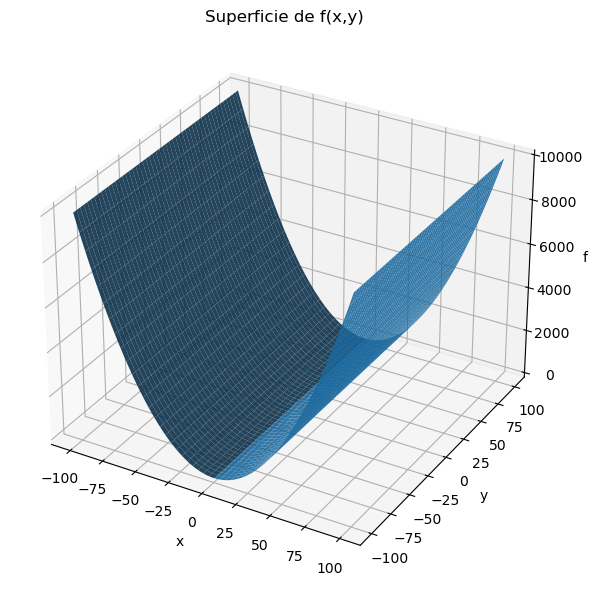

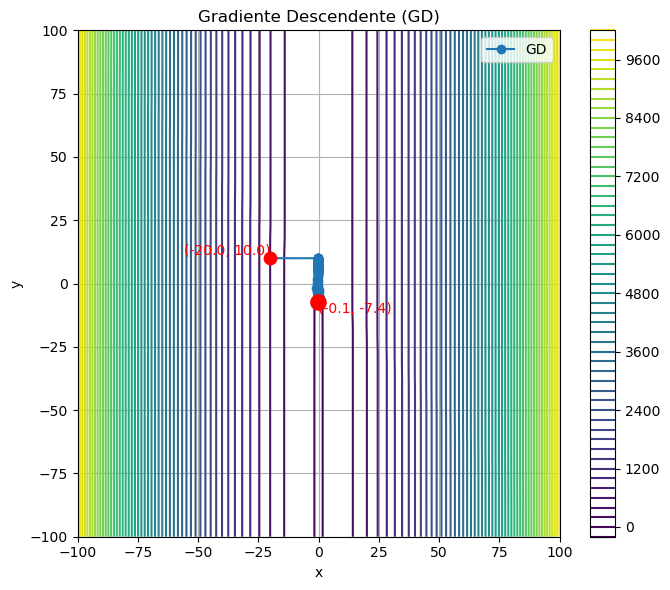

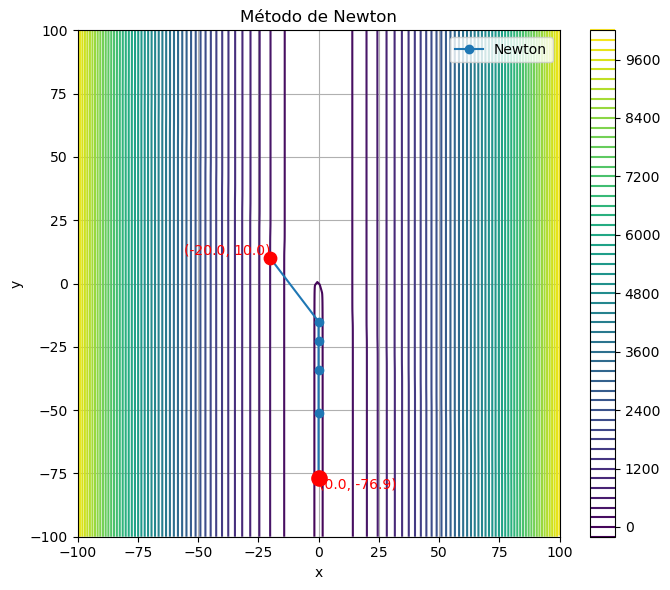

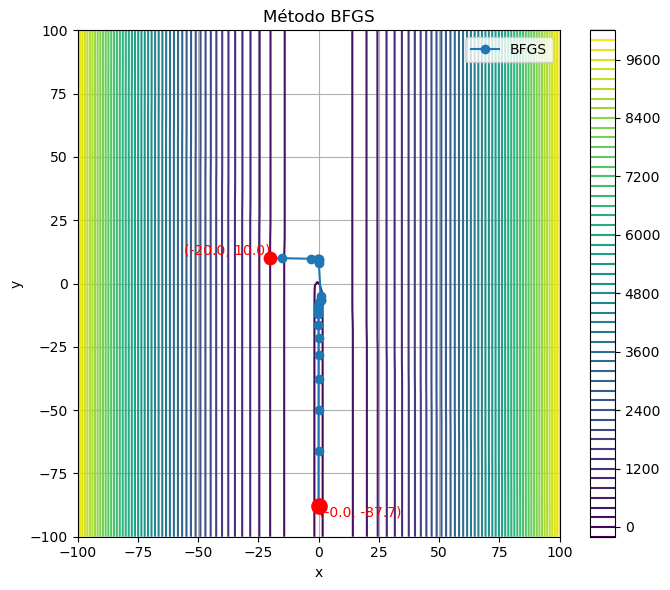

In [269]:
#Surface
fig_surf, ax_surf, X, Y, Z = plot_surface_only()
fig_surf.savefig("figures/surface.png", dpi=150)

#GD Contours
fig_gd, ax_gd, Xg, Yg, Zg = plot_contours_only()

res_gd = gradient_descent_backtracking([-20,10], max_iter=200)
plot_trajectory_on_contours(ax_gd, res_gd["trajectory"], label="GD")
ax_gd.set_title("Gradiente Descendente (GD)") 

ax_gd.legend()
fig_gd.savefig("figures/gd_contours.png", dpi=150)

#Newton Contours
fig_new, ax_new, Xn, Yn, Zn = plot_contours_only()

res_new = run_newton([-20,10], max_iter=200)
plot_trajectory_on_contours(ax_new, res_new["trajectory"], label="Newton")
ax_new.set_title("Método de Newton")

ax_new.legend()
fig_new.savefig("figures/newton_contours.png", dpi=150)

#BFGS Contours
fig_bfgs, ax_bfgs, Xb, Yb, Zb = plot_contours_only()

res_bfgs = run_bfgs([-20,10], maxiter=200)
plot_trajectory_on_contours(ax_bfgs, res_bfgs["trajectory"], label="BFGS")
ax_bfgs.set_title("Método BFGS")

ax_bfgs.legend()
fig_bfgs.savefig("figures/bfgs_contours.png", dpi=150)



# Número de iteraciones vs punto inicial

In [270]:
def plot_iterations_2d(df):
    """
    Grafica nit (iteraciones) en función de los puntos iniciales (x0,y0),
    usando un índice como eje X y color por método.
    """

    plt.figure(figsize=(14,6))

    # Creamos una lista de pares iniciales únicos y les asignamos un índice
    unique_points = df[["x0_x", "x0_y"]].drop_duplicates().reset_index(drop=True)
    unique_points["idx"] = np.arange(len(unique_points))

    # Fusionar indices con el df original
    df2 = df.merge(unique_points, on=["x0_x","x0_y"])

    colors = {
        "GD": "green",
        "BFGS": "blue",
        "Newton": "orange"
    }

    markers = {
        "GD": "o",
        "BFGS": "s",
        "Newton": "D"
    }

    for method in df2["method"].unique():
        sub = df2[df2["method"] == method]
        plt.scatter(
            sub["idx"],
            sub["nit"],
            color=colors.get(method, "black"),
            marker=markers.get(method, "o"),
            label=method,
            s=60
        )

    # Etiquetas estéticas
    plt.xticks(
        unique_points["idx"],
        [f"({x},{y})" for x, y in zip(unique_points["x0_x"], unique_points["x0_y"])],
        rotation=90
    )
    
    plt.ylabel("Iteraciones (nit)")
    plt.xlabel("Punto inicial (x0, y0)")
    plt.title("Iteraciones en función del punto inicial para cada algoritmo")

    plt.legend()
    plt.tight_layout()

    # Guardar la figura
    plt.savefig("figures/iterations_vs_initial_points.png", dpi=150)

    plt.show()


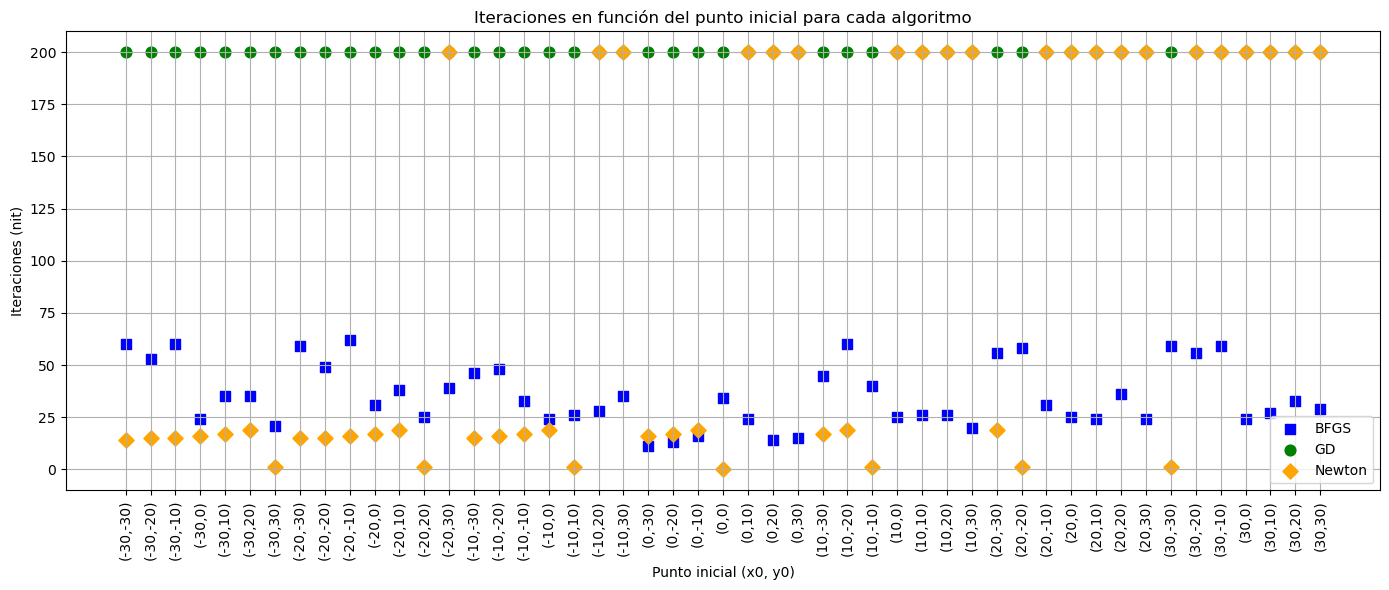

In [271]:
df = pd.read_csv("results_test_full.csv")   # tu CSV real
plot_iterations_2d(df)


# Valor de f vs punto inicial

In [272]:
def plot_f_final_2d(df):
    """
    Grafica f_final en función del punto inicial (x0, y0),
    usando un índice como eje X y color por método.
    """
    plt.figure(figsize=(12,6))

    # Crear índices para cada punto inicial
    unique_points = df[["x0_x", "x0_y"]].drop_duplicates().reset_index(drop=True)
    unique_points["idx"] = np.arange(len(unique_points))

    # Combinar con dataframe original
    df2 = df.merge(unique_points, on=["x0_x","x0_y"])

    colors = {"GD": "green", "BFGS": "blue", "Newton": "orange"}
    markers = {"GD": "o", "BFGS": "s", "Newton": "D"}

    for method in df2["method"].unique():
        sub = df2[df2["method"] == method]
        plt.scatter(
            sub["idx"], sub["f_final"],
            color=colors.get(method, "black"),
            marker=markers.get(method, "o"),
            label=method,
            s=60
        )

    # Poner etiquetas del punto inicial (x0,y0)
    plt.xticks(
        unique_points["idx"],
        [f"({x},{y})" for x, y in zip(unique_points["x0_x"], unique_points["x0_y"])],
        rotation=90
    )

    yticks = plt.yticks()[0]                
    all_ticks = list(yticks) + [-np.pi]     
    all_ticks = sorted(set(all_ticks))      

    labels = []
    for t in all_ticks:
        if abs(t + np.pi) < 1e-6:           
            labels.append(r"$-\pi$")
        else:
            labels.append(f"{t:.0f}")       

    plt.yticks(all_ticks, labels)


    plt.ylabel("Valor final f(x_final)")
    plt.xlabel("Punto inicial (x0, y0)")
    plt.title("Valor final de f según punto inicial y método")
    plt.legend()
    plt.tight_layout()

    # ⭐ Guardar figura
    plt.savefig("figures/f_final_vs_initial_points.png", dpi=150)

    plt.show()


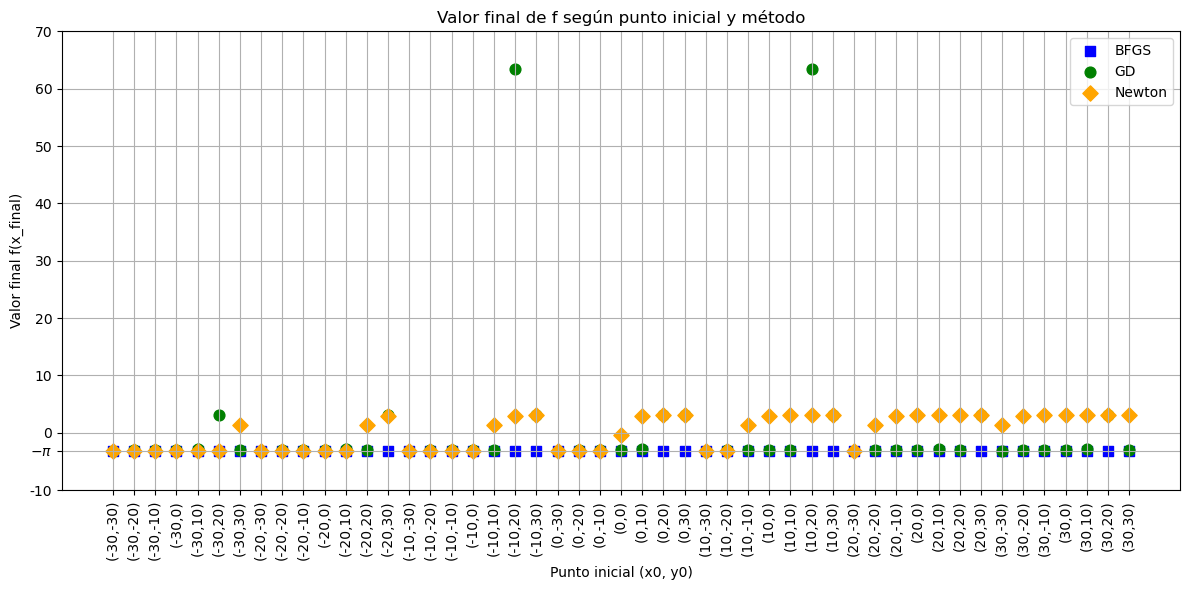

In [273]:
df = pd.read_csv("results_test_full.csv")   # tu CSV real
plot_f_final_2d(df)

# X final vs punto inicial

In [274]:
def plot_x_final_2d(df):
    """
    Grafica f_final en función del punto inicial (x0, y0),
    usando un índice como eje X y color por método.
    """
    plt.figure(figsize=(12,6))

    # Crear índices para cada punto inicial
    unique_points = df[["x0_x", "x0_y"]].drop_duplicates().reset_index(drop=True)
    unique_points["idx"] = np.arange(len(unique_points))

    # Combinar con dataframe original
    df2 = df.merge(unique_points, on=["x0_x","x0_y"])

    colors = {"GD": "green", "BFGS": "blue", "Newton": "orange"}
    markers = {"GD": "o", "BFGS": "s", "Newton": "D"}

    for method in df2["method"].unique():
        sub = df2[df2["method"] == method]
        plt.scatter(
            sub["idx"], sub["x_final_x"],
            color=colors.get(method, "black"),
            marker=markers.get(method, "o"),
            label=method,
            s=60
        )

    # Poner etiquetas del punto inicial (x0,y0)
    plt.xticks(
        unique_points["idx"],
        [f"({x},{y})" for x, y in zip(unique_points["x0_x"], unique_points["x0_y"])],
        rotation=90
    )

    plt.ylabel("Valor final x(x_final)")
    plt.xlabel("Punto inicial (x0, y0)")
    plt.title("Valor final de f según punto inicial y método")
    plt.legend()
    plt.tight_layout()

    # ⭐ Guardar figura
    plt.savefig("figures/x_final_vs_initial_points.png", dpi=150)

    plt.show()


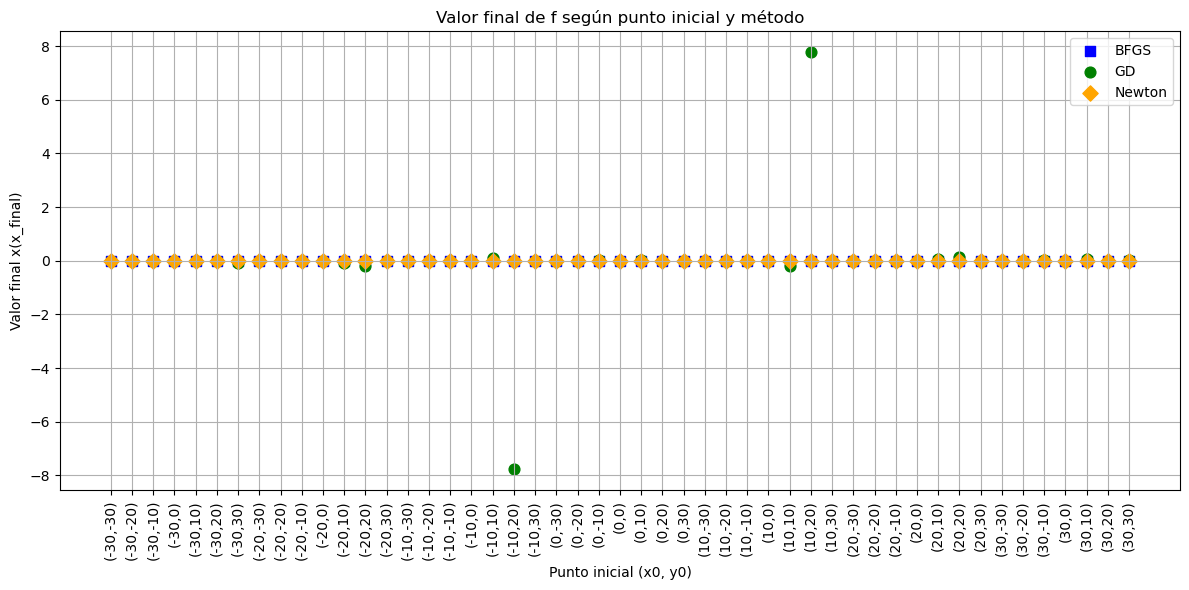

In [275]:
df = pd.read_csv("results_test_full.csv")   # tu CSV real
plot_x_final_2d(df)

# Y final vs punto inicial 

In [276]:
def plot_y_final_2d(df):
    """
    Grafica f_final en función del punto inicial (x0, y0),
    usando un índice como eje X y color por método.
    """
    plt.figure(figsize=(12,6))

    # Crear índices para cada punto inicial
    unique_points = df[["x0_x", "x0_y"]].drop_duplicates().reset_index(drop=True)
    unique_points["idx"] = np.arange(len(unique_points))

    # Combinar con dataframe original
    df2 = df.merge(unique_points, on=["x0_x","x0_y"])

    colors = {"GD": "green", "BFGS": "blue", "Newton": "orange"}
    markers = {"GD": "o", "BFGS": "s", "Newton": "D"}

    for method in df2["method"].unique():
        sub = df2[df2["method"] == method]
        plt.scatter(
            sub["idx"], sub["x_final_y"],
            color=colors.get(method, "black"),
            marker=markers.get(method, "o"),
            label=method,
            s=60
        )

    # Poner etiquetas del punto inicial (x0,y0)
    plt.xticks(
        unique_points["idx"],
        [f"({x},{y})" for x, y in zip(unique_points["x0_x"], unique_points["x0_y"])],
        rotation=90
    )

    plt.ylabel("Valor final y(x_final)")
    plt.xlabel("Punto inicial (x0, y0)")
    plt.title("Valor final de y según punto inicial y método")
    plt.legend()
    plt.tight_layout()
    plt.ylim(-25000, 10000)

    # ⭐ Guardar figura
    plt.savefig("figures/y_final_vs_initial_points.png", dpi=150)
    

    plt.show()


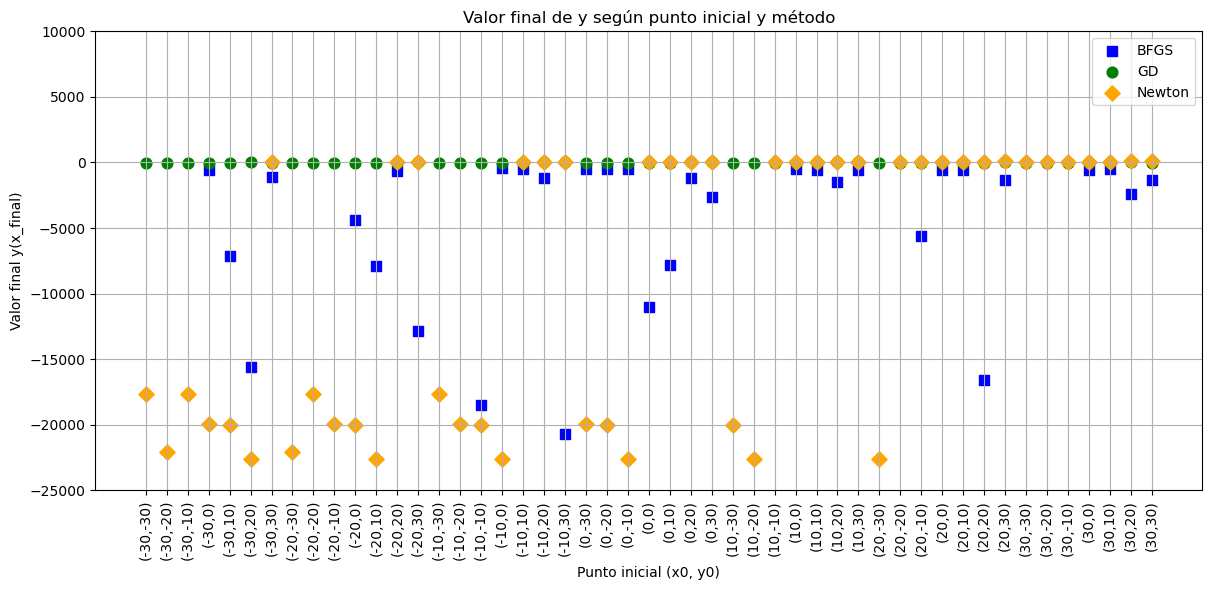

In [277]:
df = pd.read_csv("results_test_full.csv")   # tu CSV real
plot_y_final_2d(df)